In [44]:
import tensorflow.keras
from keras import backend as K 
from tensorflow.keras.models import Sequential
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, MaxPooling2D 
from tensorflow.keras.utils import to_categorical
from keras.models import Model     
from keras.layers import concatenate, Dropout, Flatten  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import optimizers, regularizers
from keras.initializers import he_normal
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from scipy.stats import randint

In [3]:
import os
import seaborn as sns
from keras.datasets import fashion_mnist

In [4]:
def load_dataset():
 # load dataset
 (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
 # reshape dataset to have a single channel
 trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
 testX = testX.reshape((testX.shape[0], 28, 28, 1))
 # one hot encode target values
 trainY_onehot_encode = to_categorical(trainY)
 testY_onehot_encode = to_categorical(testY)
 return trainX, trainY, testX, testY, trainY_onehot_encode, testY_onehot_encode 

In [5]:
trainX, trainY, testX, testY, trainY_onehot_encode, testY_onehot_encode = load_dataset()

4431872/4422102 [==============================] - 2s 0us/step


In [7]:
trainX, testX = trainX / 255.0, testX / 255.0

In [13]:
print(trainX.shape)
print(trainY.shape)
print(trainY_onehot_encode.shape)

(60000, 28, 28, 1)
(60000,)
(60000, 10)


In [31]:
def define_model():
    activation = 'relu'

    # Define the input layer
    input_layer = Input(shape=(28, 28, 1))

    # Feature extractor model using functional API
    x = Conv2D(32, 3, activation=activation, padding='same')(input_layer)
    x = BatchNormalization()(x)

    x = Conv2D(32, 3, activation=activation, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, activation=activation, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, 3, activation=activation, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Feature extractor output
    feature_extractor_output = Flatten()(x)

    # Define the prediction layer
    x = Dense(128, activation=activation, kernel_initializer='he_uniform')(feature_extractor_output)
    prediction_layer = Dense(10, activation='softmax')(x)

    # Create the feature extractor model
    feature_extractor = Model(inputs=input_layer, outputs=feature_extractor_output)

    # Create the full model
    model = Model(inputs=input_layer, outputs=prediction_layer)

    return feature_extractor, model

In [32]:
feature_extractor,model=define_model()
model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24_input (InputLayer  [(None, 28, 28, 1)]      0         
 )                                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_24 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_25 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                           

In [34]:
history = model.fit(trainX, trainY_onehot_encode, epochs=3, validation_split=0.33, batch_size = 32)

Epoch 1/3
1257/1257 [==============================] - 111s 86ms/step - loss: 0.4675 - accuracy: 0.8479 - val_loss: 0.3777 - val_accuracy: 0.8688
Epoch 2/3
1257/1257 [==============================] - 105s 83ms/step - loss: 0.2917 - accuracy: 0.9005 - val_loss: 0.4237 - val_accuracy: 0.8641
Epoch 3/3
1257/1257 [==============================] - 105s 83ms/step - loss: 0.2321 - accuracy: 0.9185 - val_loss: 0.3165 - val_accuracy: 0.9087


In [35]:
X_for_RF = feature_extractor.predict(trainX)

In [36]:
X_test_feature = feature_extractor.predict(testX)

In [40]:
print(X_test_feature.shape)
print(X_for_RF.shape)

(10000, 3136)
(60000, 3136)


In [49]:
param_dist = {'n_estimators': randint(0,50),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5,
                                random_state = 42)


In [50]:
# Fit the random search object to the data
rand_search.fit(X_for_RF,trainY)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000165C668D5E0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016599808EE0>},
                   random_state=42)

In [51]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_
# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 42}


In [52]:
#Now predict using the trained RF model. 
prediction_RF = rand_search.predict(X_test_feature)

In [54]:
cm = confusion_matrix(testY, prediction_RF)

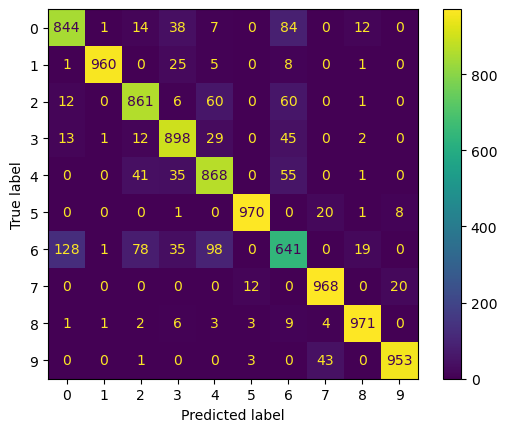

In [55]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [57]:
print ("Accuracy = ", accuracy_score(testY, prediction_RF))

Accuracy =  0.8934
